In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
import warnings
warnings.filterwarnings('ignore')

import time
import argparse
import gc
import pandas
import lightgbm

/Users/hernando/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('/Users/hernando/Desktop/datamining1/assign2/2nd-assignment-dmt-2020/training_set_VU_DM.csv',sep=',')
# test = pd.read_csv('/Users/hernando/Desktop/datamining1/assign2/2nd-assignment-dmt-2020/test_set_VU_DM.csv',sep=',')

In [8]:
train_copy = train.copy()
# test_copy = test.copy()

In [9]:
target_score = [train_copy["click_bool"] == 1,train_copy["booking_bool"] == 1]
choices = [1, 2]
train_copy['score'] = np.select(target_score, choices, default=0)
# score_final = data_training['score'].values

In [10]:
def missing_data_process(df,file):
    
    df['avg_comp_rate'] = df[['comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']].mean(axis=1)
    df = df.drop(['comp1_rate', "comp1_inv", "comp1_rate_percent_diff", 'comp2_rate', "comp2_inv", "comp2_rate_percent_diff", 'comp3_rate', "comp3_inv", "comp3_rate_percent_diff", 'comp4_rate', "comp4_inv", "comp4_rate_percent_diff", 'comp5_rate', "comp5_inv", "comp5_rate_percent_diff", 'comp6_rate', "comp6_inv", "comp6_rate_percent_diff", 'comp7_rate', "comp7_inv", "comp7_rate_percent_diff", 'comp8_rate', "comp8_inv", "comp8_rate_percent_diff"], axis = 1)
    df = df.fillna(value = {"avg_comp_rate": 0}) 
    
    if file =='train':
        df = df.drop(['gross_bookings_usd'],axis=1)

    df["orig_destination_distance"].fillna(df["orig_destination_distance"].describe()[6], inplace=True)
    df['visitor_hist_starrating'].fillna(df['visitor_hist_starrating'].median(axis = 0, skipna=True) ,inplace=True)
    df['visitor_hist_adr_usd'].fillna(df['visitor_hist_adr_usd'].median(axis = 0, skipna=True),inplace=True)
    df["srch_query_affinity_score"].fillna(df["srch_query_affinity_score"].min(), inplace=True)
    df['roomcount_bookwindow'] = df['srch_room_count']*max(df['srch_booking_window']) + df['srch_booking_window']
    df['adultcount_childrencount'] = df['srch_adults_count']*max(df['srch_children_count']) + df['srch_children_count']
    
    return df

In [11]:
train_change = missing_data_process(train_copy,file='train')
# test_change = missing_data_process(test,file='test')

In [27]:
all_data_na = (for_train.isnull().sum() / len(for_train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
srch_id_norm_prop_location_score2,22.107190
Substract_srch_id_norm_prop_location_score2,21.995588
prop_location_score2,21.995588
Mean_srch_id_norm_prop_location_score2,1.856846
srch_id_norm_prop_starrating,1.820990
prop_id_norm_price_usd,0.318359
srch_id_norm_prop_review_score,0.195210
Substract_srch_id_norm_prop_review_score,0.148672
prop_review_score,0.148672
srch_id_norm_prop_location_score1,0.021077


In [16]:
all_data_na = (test_change.isnull().sum() / len(test_change)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
prop_location_score2,21.939743
prop_review_score,0.146516


In [7]:
def log_ten(input_,target):
    input_data = input_.copy()
    
    input_data[target] = np.log10(input_data[target] + 1e-4)
    return input_data


def normalize_combine(input_, group, target, combine = 'normal'):
    input_data = input_.copy()
    methods=['mean','std']
    df = input_data.groupby(group).agg({target: methods})
    ##drop the firs layer of column
    df.columns = df.columns.droplevel()
    col = {}
    for method in methods:
        col[method] = target + "_" + method
    df.rename(columns=col, inplace=True)
    merge_data = input_data.merge(df.reset_index(), on=group)
#     print(merge_data)
    
    ##using now price - mean /std
    if combine =='normal':
        merge_data[group + "_norm_" + target] = (merge_data[target] - merge_data[target + "_mean"]) /merge_data[target + "_std"]
        merge_data = merge_data.drop(labels=[col["mean"], col["std"]], axis=1)
    else:
        merge_data['Mean_' + group + "_norm_" + target] = merge_data[target + "_mean"]
        merge_data['Substract_' + group + "_norm_" + target] =(merge_data[target] - merge_data[target + "_mean"])
        merge_data = merge_data.drop(labels=[col["mean"], col["std"]], axis=1)
    gc.collect()
    return merge_data

def data_processing(original_data, catogery = 'train'):
    print('Begin data processing>>>>>>>')
    gc.collect()
    data_training = original_data.copy()
    
    if catogery == "train":
        target_score = [data_training["click_bool"] == 1,data_training["booking_bool"] == 1]
        choices = [1, 2]
        data_training['score'] = np.select(target_score, choices, default=0)
        score_final = data_training['score'].values
    else:
        score_final=1
    
    ##processing date column
    dates = pandas.to_datetime(data_training["date_time"])
    data_training["month"] = dates.dt.month
    data_training["dayofweek"] = dates.dt.dayofweek
    data_training["hour"] = dates.dt.hour
    
    print("Normalize training data>>>>>>")
    data_training = log_ten(data_training,"price_usd")
    ## for price_use
    data_training = normalize_combine(data_training,"srch_id","price_usd", combine='normal')
    data_training = normalize_combine(data_training,"prop_id","price_usd", combine='normal')
    
    ## for star
    data_training = normalize_combine(data_training,"srch_id","prop_starrating", combine='normal')
#     data_training = normalize_combine(data_training,"prop_id","prop_starrating", combine='normal')
    
    
    print(" Combine training data>>>>>>")
    ##for pop 
    data_training = normalize_combine(data_training,"prop_id","price_usd",combine='combine')
    data_training = normalize_combine(data_training,"srch_id","prop_starrating",combine='combine')
    
    data_training = normalize_combine(data_training,"srch_id","prop_location_score2",combine='combine')
    data_training = normalize_combine(data_training,"srch_id","prop_location_score1",combine='combine')
    data_training = normalize_combine(data_training,"srch_destination_id","price_usd",combine='combine')
    data_training = normalize_combine(data_training,"srch_id","prop_review_score",combine='combine')
    data_training = normalize_combine(data_training,"srch_id","promotion_flag",combine='combine')

    print(" Sort training data>>>>>>")
    data_training = data_training.sort_values("srch_id")
    data_training = normalize_combine(data_training,"srch_id","prop_starrating", combine='normal')
    data_training = normalize_combine(data_training,"srch_id","prop_location_score2",combine='normal')
    data_training = normalize_combine(data_training,"srch_id","prop_location_score1",combine='normal')
    data_training = normalize_combine(data_training,"srch_id","prop_review_score", combine='normal')
    gc.collect()
    
    #remove useless column
    if catogery == 'train':
        data_training = data_training.drop(["click_bool", "booking_bool","date_time",'score'], axis=1)
        

    return data_training,score_final
    

# processing train

In [8]:
def combine_normal(train_change):

    train_10 = log_ten(train_change,"price_usd")
    train_10 = normalize_combine(train_10,"srch_id","price_usd", combine='normal')
    train_10 = normalize_combine(train_10,"prop_id","price_usd", combine='normal')
    train_10 = normalize_combine(train_10,"srch_id","prop_starrating", combine='normal')
    
    train_10 = normalize_combine(train_10,"prop_id","price_usd",combine='combine')
    train_10 = normalize_combine(train_10,"srch_id","prop_starrating",combine='combine')
    train_10 = normalize_combine(train_10,"srch_id","prop_location_score2",combine='combine')
    train_10 = normalize_combine(train_10,"srch_id","prop_location_score1",combine='combine')
    train_10 = normalize_combine(train_10,"srch_destination_id","price_usd",combine='combine')
    train_10 = normalize_combine(train_10,"srch_id","prop_review_score",combine='combine')
    train_10 = normalize_combine(train_10,"srch_id","promotion_flag",combine='combine')
    train_30 = train_10.drop(['Substract_srch_destination_id_norm_price_usd'],axis=1)
    
    train_30 = train_30.sort_values("srch_id")
    train_30 = normalize_combine(train_30,"srch_id","prop_starrating", combine='normal')
    train_30 = normalize_combine(train_30,"srch_id","prop_location_score2",combine='normal')
    train_30 = normalize_combine(train_30,"srch_id","prop_location_score1",combine='normal')
    train_30 = normalize_combine(train_30,"srch_id","prop_review_score", combine='normal')

    return train_30


In [9]:
train_30 = combine_normal(train_change)

In [10]:
target_score = [train_30["click_bool"] == 1,train_30["booking_bool"] == 1]
choices = [1, 2]
train_30['score'] = np.select(target_score, choices, default=0)
score_final = train_30['score'].values

dates = pandas.to_datetime(train_30["date_time"])
train_30["month"] = dates.dt.month
train_30["dayofweek"] = dates.dt.dayofweek
train_30["hour"] = dates.dt.hour

train_30  = train_30.drop(["click_bool", "booking_bool","date_time",'score'], axis=1)

In [43]:
train_30.to_csv('after_combine_missing.csv',index=False)
# len(for_train.columns)

In [2]:
train_30 = pd.read_csv('after_combine_missing.csv')
score_final = pd.read_csv('score_final.csv')

In [10]:
# train_after_original = pd.read_csv('correct_answer.csv')
# train_after_original = train_after_original.drop(['Unnamed: 0'],axis=1)

In [11]:
def deal_position(input_):
    df = input_.copy()
    position_dict = df.loc[df["random_bool"] == 0]
    ##main idea is using "srch_destination_id", "prop_id" to deal with position
    
    ##srch_destination_id:ID of the destination where the hotel search was performed
    ## ID of hotel:The ID of the hotel
    position_dict = df.groupby(["srch_destination_id", "prop_id"]).agg({"position": "mean"})
    ##let the srch_destination_id prop_id become column
    position_dict = position_dict.rename(index=str, columns={"position": "es_position"}).reset_index()
    position_dict["srch_destination_id"] = position_dict["srch_destination_id"].astype(int)
    position_dict["prop_id"] = position_dict["prop_id"].astype(int)
    position_dict["es_position"] = (1 / position_dict["es_position"])
    
    return position_dict



def pre_train_valid(input_,score):
    df = input_.copy()
    for_train = df[100000:]
    for_valid = df[0:100000]
    y_for_train = score[100000:]
    y_for_valid = score[0:100000]
    
    #for prediction
    print('Pre position>>>>>>>>.')
    predict_dict = deal_position(df)

    for_train = for_train.merge(predict_dict, how="left", on=["srch_destination_id", "prop_id"])
    for_valid = for_valid.merge(predict_dict, how="left", on=["srch_destination_id", "prop_id"])
    ###gruop number of srch_id -person
    train_person = for_train["srch_id"].value_counts(sort=False).sort_index()
    vali_person = for_valid["srch_id"].value_counts(sort=False).sort_index()
    
    for_train = for_train.drop(["srch_id",'position',"prop_id","random_bool"],axis=1)
    for_valid = for_valid.drop(["srch_id",'position',"prop_id","random_bool"],axis=1)
    
    
    return for_train, for_valid, y_for_train, y_for_valid, train_person, vali_person,predict_dict
    
    

In [12]:
for_train, for_valid, y_for_train, y_for_valid, train_person, vali_person,predict_dict = pre_train_valid(train_30, score_final)

Pre position>>>>>>>>.


In [22]:
def pre_model(for_train, for_valid, y_for_train, y_for_valid, train_person, vali_person,):
    str(int(time.time()))
    
    features_cato = ["site_id","month","prop_country_id","visitor_location_country_id",]
    catogery_feature = [for_train.columns.get_loc(x) for x in features_cato]
    print(catogery_feature)
    
    lgbm = lightgbm.LGBMRanker(n_estimators=1500, learning_rate=0.12, max_position=5,label_gain=[0, 1, 2],
                               random_state=69,
                                seed=69,
                                boosting="dart",
                              objective="lambdarank",
                                metric="ndcg",)
    lgbm.fit(for_train,y_for_train,eval_set=[(for_train,y_for_train), (for_valid, y_for_valid)],eval_group=[train_person, vali_person],group=train_person,eval_at=5,
         verbose=20,
        early_stopping_rounds=200,
        categorical_feature= catogery_feature)
    
    return lgbm

In [23]:
lgbm =pre_model(for_train, for_valid, y_for_train, y_for_valid, train_person, vali_person,)

[0, 42, 4, 1]
[20]	training's ndcg@5: 0.402322	valid_1's ndcg@5: 0.403171
[40]	training's ndcg@5: 0.405727	valid_1's ndcg@5: 0.406292
[60]	training's ndcg@5: 0.408288	valid_1's ndcg@5: 0.406521
[80]	training's ndcg@5: 0.409978	valid_1's ndcg@5: 0.405273
[100]	training's ndcg@5: 0.413584	valid_1's ndcg@5: 0.410314
[120]	training's ndcg@5: 0.417511	valid_1's ndcg@5: 0.411606
[140]	training's ndcg@5: 0.419407	valid_1's ndcg@5: 0.411519
[160]	training's ndcg@5: 0.420485	valid_1's ndcg@5: 0.41173
[180]	training's ndcg@5: 0.421516	valid_1's ndcg@5: 0.412616
[200]	training's ndcg@5: 0.423096	valid_1's ndcg@5: 0.411401
[220]	training's ndcg@5: 0.424129	valid_1's ndcg@5: 0.412999
[240]	training's ndcg@5: 0.426217	valid_1's ndcg@5: 0.413348
[260]	training's ndcg@5: 0.427365	valid_1's ndcg@5: 0.414623
[280]	training's ndcg@5: 0.428218	valid_1's ndcg@5: 0.413539
[300]	training's ndcg@5: 0.429754	valid_1's ndcg@5: 0.413951
[320]	training's ndcg@5: 0.431151	valid_1's ndcg@5: 0.414718
[340]	training'

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45],
 <a list of 46 Text xticklabel objects>)

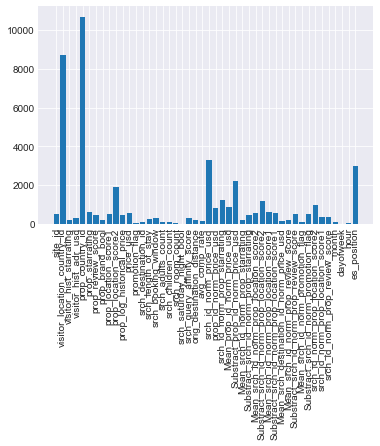

In [24]:
plt.bar(for_train.columns,lgbm.feature_importances_)
plt.xticks(rotation=90)

In [16]:
lgbm =pre_model(for_train, for_valid, y_for_train, y_for_valid, train_person, vali_person,)

[0, 42, 4, 1]
[20]	training's ndcg@5: 0.402322	valid_1's ndcg@5: 0.403171
[40]	training's ndcg@5: 0.405724	valid_1's ndcg@5: 0.406292
[60]	training's ndcg@5: 0.408709	valid_1's ndcg@5: 0.406257
[80]	training's ndcg@5: 0.409908	valid_1's ndcg@5: 0.408191
[100]	training's ndcg@5: 0.413648	valid_1's ndcg@5: 0.408588
[120]	training's ndcg@5: 0.417742	valid_1's ndcg@5: 0.410136
[140]	training's ndcg@5: 0.419257	valid_1's ndcg@5: 0.41238
[160]	training's ndcg@5: 0.420303	valid_1's ndcg@5: 0.413549
[180]	training's ndcg@5: 0.421618	valid_1's ndcg@5: 0.412952
[200]	training's ndcg@5: 0.422973	valid_1's ndcg@5: 0.413566
[220]	training's ndcg@5: 0.423844	valid_1's ndcg@5: 0.415128
[240]	training's ndcg@5: 0.426199	valid_1's ndcg@5: 0.415463
[260]	training's ndcg@5: 0.42733	valid_1's ndcg@5: 0.416175
[280]	training's ndcg@5: 0.428127	valid_1's ndcg@5: 0.415677
[300]	training's ndcg@5: 0.429603	valid_1's ndcg@5: 0.415492
[320]	training's ndcg@5: 0.431066	valid_1's ndcg@5: 0.416702
[340]	training's

In [25]:
lgbm.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('ndcg@5', 0.47855121196509326)]),
             'valid_1': OrderedDict([('ndcg@5', 0.41790134392686623)])})

# predict_test

In [26]:
test = pd.read_csv('/Users/hernando/Desktop/datamining1/assign2/2nd-assignment-dmt-2020/test_set_VU_DM.csv',sep=',')

In [29]:
test_copy = test.copy()

In [30]:
test_change = missing_data_process(test_copy,file='test')

In [31]:
test_30 = combine_normal(test_change)
dates = pandas.to_datetime(test_30["date_time"])
test_30["month"] = dates.dt.month
test_30["dayofweek"] = dates.dt.dayofweek
test_30["hour"] = dates.dt.hour
test_30  = test_30.drop(["date_time"], axis=1)

In [32]:
for_test = test_30.merge(predict_dict, how="left", on=["srch_destination_id", "prop_id"])
for_test = for_test.drop(['prop_id', 'random_bool', 'srch_id'],axis=1)

In [33]:
features_cato = ["site_id","month","prop_country_id","visitor_location_country_id",]

catogrey_for_test = [for_test.columns.get_loc(x) for x in features_cato]
catogrey_for_test

[0, 42, 4, 1]

In [34]:
kwargs = {"categorical_feature": catogrey_for_test}
predictions = lgbm.predict(for_test, **kwargs)

In [38]:
testforfinal= test_copy[["srch_id", "prop_id"]]
testforfinal["prediction"] = predictions

In [42]:
test_set_submission_result = testforfinal.groupby(["srch_id"]).apply(
        lambda x: x.sort_values(["prediction"], ascending=False)).reset_index(drop=True)
print("\nStore the predictions...\n")
test_set_submission_result = test_set_submission_result.drop("prediction", axis=1)
# store the file to submit!
test_set_submission_result.to_csv("submission_twice", index=False)



Store the predictions...

